In [10]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
from astropy.timeseries import LombScargle
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import os
import pickle

# Functions

In [2]:
def lorentzian_components(params_gr, t):

    '''
    Simulated effects of pulsations and granulations
    
    source: Dumusque et al 2011
    https://www.aanda.org/articles/aa/pdf/2011/01/aa14097-10.pdf
    
    Inputs
        - params_gr := A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste
        - t = time in seconds

    ''' 
    
    # define frequency arrays  
    # The frequency ν goes from 1/T to the Nyquist frequency in steps of 1/T
    N    = len(t)
    Ttot = (max(t)-min(t)) # total time in seconds
    dt = np.median(np.diff(t)) # sampling rate
    freq_Nyq = (1.0/dt)/2 # Nyquist frequency
    freq  = np.arange(1.0/Ttot,freq_Nyq,1.0/Ttot, dtype='float64')
    # freq  = np.linspace(1.0/Ttot, 1./2/dt, len(t)) # Hz

    # define the power spectra as a sum of 3 components for granulation, mesogranulation and supergranulation + oscillations
    A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste = params_gr 
    
    VPSD = A1 / (1+(B1*freq)**C1) + A2 / (1+(B2*freq)**C2) +  A3 / (1+(B3*freq)**C3) + \
                AL * (Gm**2/((freq-nu0)**2+Gm**2)) +  cste  
    
    #VPSD /= 1e6     # units of VPSD is (m/s)**2/Hz
    VPSD *= (freq[-1] - freq[0])
           
    # take random phase between 0 and 2pi
    phase = 2*np.pi*np.random.rand(1,len(VPSD))
    #print(len(phase), len(VPSD))
    
    # Synthetic radial velocity measurements
    ysyn = np.zeros(N)
    for i in range(N):
        ysyn[i] = np.sum(np.sqrt(VPSD)*np.sin(2*np.pi*t[i]*freq+phase))
       
    return ysyn




def generate_regular_data_H0(params_gr, params_act, t):
    
    '''
    Inputs:
    - params_gr:= 
            see function lorentzian_components(params_gr, t)
    - params_act:=
            - amplitude (GP amplitude)
            - gam = 2/epsilon in the paper (GP gamma)
            - logP = log(P) in the paper (GP period)
            - met = 1.0 in the paper (GP metric)
    
    - N = number of data points
        
    Outputs:
        - t = time (days)
        - y = RV (m/s)
        - yerr =  intrinsic errors (m/s)
    '''
    
    # =========================================================================
    # Generate a Lorentzian component that represents the pulsations and
    # three components for the granulation, mesogranulation and su-
    # pergranulation
    ts    = t*24*3600 # seconds
    ygr = lorentzian_components(params_gr, ts)
    
    # =========================================================================
    # Generate activity component based on GP
    
    # define the QP kernel for the GP (see https://george.readthedocs.io/en/latest/user/kernels/)
    amp, gam, logP, met  = params_act
    k  = kernels.ExpSine2Kernel(gamma=gam, log_period=logP)
    k *= kernels.ExpSquaredKernel(metric=met) # metric correspondind to r^2/lambda  is 1
    k *= amp**2 
    # print(k.get_parameter_vector())
    
    gp = george.GP(k)

    # generate synthetic dataset
    yact = gp.sample(t)
    
    # =========================================================================
    # Generate the intrincsic errors
    eb = np.random.normal(loc=3,scale=0.30, size=len(t)) # m/s
    if (eb < 0) : eb = np.where(eb<0, 1.5, eb)
    yerr = np.random.normal(loc=0, scale=eb, size=len(t)) # this has to be defined according to the paper
    #print('std(yerr) = %f m/s'%np.std(yerr))

    # =========================================================================
    # Generate the final synthetic time series
    # activity + granulation + the intrinsic errors 
    ytot = ygr + yact + yerr * np.random.randn(len(t))
    
    #return ygr,yact, yerr* np.random.randn(N)
    return ytot, eb




def generate_planete(params_pl,t):
    """
    - params_pl
            - Ppl (Orbital period)
            - K (semi-amplitude)
            - T0 ( Phase à l'origine)
    """
    Ppl, K, T0 = params_pl
    return K*np.sin(2*np.pi*(t-T0)/Ppl)



def print_4periodogramme(LS_p,label,freq_pl,i):
    LS = LS_p[:,i,:]
    f1,f2,f3,f4 = freq_pl[i,:]
    l1,l2,l3,l4 = label[i,:]
    
    plt.figure()
    plt.suptitle("4 Lomb-Scargle peridogramme generated by removing the best fit\n"+str(i)+" planet")
    plt.subplot(411),plt.plot(freq, LS[:,0] , label =l1), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,0]),max(LS[:,0])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,0]),max(LS[:,0])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,0]),max(LS[:,0])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,0]),max(LS[:,0])],'y--')

    plt.subplot(412), plt.plot(freq, LS[:,1] , label =l2), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,1]),max(LS[:,1])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,1]),max(LS[:,1])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,1]),max(LS[:,1])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,1]),max(LS[:,1])],'y--')

    plt.subplot(413), plt.plot(freq, LS[:,2] , label =l3), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,2]),max(LS[:,2])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,2]),max(LS[:,2])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,2]),max(LS[:,2])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,2]),max(LS[:,2])],'y--')

    plt.subplot(414 ), plt.plot(freq, LS[:,3] , label = l4), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,3]),max(LS[:,3])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,3]),max(LS[:,3])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,3]),max(LS[:,3])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,3]),max(LS[:,3])],'y--')
    
    plt.xlabel("Frequency (day⁻¹)")
    plt.ylabel("Power")
    

def generate_4_periodogrammes(t,f, y, freq_pl,nbr_planete,eb):
    """
    Parameters
    ----------
    t : time (day)
    f : frequency ( day⁻1)
    y : original time serie

    Returns
    -------
    4 times series with their lomb-scargle 
    """
    y_t = np.zeros((len(t), 4)) #time series
    LS  = np.zeros((len(f), 4)) # 4 lombscargle 
    nbr_planete_now = np.copy(nbr_planete)
    label= np.zeros(4) #(1 if max = freq_pl, 0 else)
    max_value = np.zeros((2,4)) # (argmax, max)
    
    y_t[:,0] = y 
    
    for i in range(3):
        LS_i =  LombScargle(t, y_t[:,i],eb)
        LS[:,i] = LS_i.power(f,method='cython')
        best_freq = round(f[np.argmax(LS[:,i])],3)
        #print("meilleur fit : ",best_freq)
        max_value[0,i], max_value[1,i] = best_freq, np.max(LS[:,i]) 
                
        if ( any(np.isclose(freq_pl, best_freq, atol=0.002)) ):
            label[i] = 1
            freq_pl[ np.where( np.isclose(freq_pl, best_freq, atol=0.002) ) ] = 0
            nbr_planete_now[i+1:] = nbr_planete_now[i] - 1
        else:
            label[i] = 0
            
        y_fit = LS_i.model(t,best_freq)
        y_t[:,i+1] = y_t[:,i] - y_fit
      
    LS_i = LombScargle(t, y_t[:,3],eb)
    LS[:,3] = LS_i.power(f,method='cython')
    best_freq = round(f[np.argmax(LS[:,3])],3)
    #print("meilleur fit : ",best_freq)
    max_value [0,3], max_value[1,3] =  best_freq, np.max(LS[:,3])
    
    if (any(np.isclose(freq_pl, best_freq, atol=0.002))):
        label[3] = 1
        freq_pl[np.where( np.isclose(freq_pl, best_freq, atol=0.002) )] = 0
    else:
        label[3] = 0
    
    #print("label = ", label)
    
    return LS, label, max_value, nbr_planete_now     



def generate_data(t,dt,Ttot,freq,params_gr, params_act):
    
    """
    Create 5 time series with respectively 0, 1, 2, 3 and 4 planets. For each time series 4 Lomb-Scargle 
    periodogrammes are generated.For each periodogramme, position and max amplitude are taken and a label is 
    created, either 1 or 0 if max amplitude correspond to a frequency planeteray signal.
    """
    
    time_series = np.zeros((len(t),5))
    LS = np.zeros((len(freq),5,4))
    freq_pl = np.zeros((5,4))
    nbr_planete = np.zeros((5,4))
    label = np.zeros((5,4))
    max_value = np.zeros((2,5,4))
    
    y_noise, eb = generate_regular_data_H0(params_gr, params_act, t) 
    
    #print("freq planet : ",freq_pl[0,:])
    time_series[:,0] = y_noise #Without planet
    LS[:,0,:], label[0,:], max_value[:,0,:],nbr_planete[0,:] = generate_4_periodogrammes(t, freq, np.copy(y_noise), freq_pl[0,:],nbr_planete[0,:],eb) #Without planet
    
    for i in range(1,5):
        y_i , eb = generate_regular_data_H0(params_gr, params_act, t) 
        for k in range(1,i+1):
            Ppl =  random.uniform(10*dt,Ttot/2) 
            K = loguniform.rvs(0.1, 10)
            T0 =  random.uniform(0,Ppl)
            params_pl = [Ppl,K,T0]
            freq_pl[i,k-1] = round(1/Ppl,3)
            
            y_pl = generate_planete(params_pl, t)
            y_i += y_pl 
        
        
        nbr_planete[i,:] = i
        #print("freq planet : ",freq_pl[i,:])
        time_series[:,i] = y_i
        LS[:,i,:], label[i,:], max_value[:,i,:],nbr_planete[i,:] = generate_4_periodogrammes(t, freq, y_i,np.copy(freq_pl[i,:]),nbr_planete[i,:],eb)
        
        
    return time_series, LS, label, max_value, freq_pl,nbr_planete


In [12]:
#Function to create the first dataset
def create_set1(nbr_periodogramme, pourcentage_positive,t, dt, Ttot, freq):
    
    count_positif = 0
    count_negatif = 0
    nbr_ech = nbr_periodogramme/5
    count_ech = np.zeros(5)
    
    X_LS = []
    X_max_values = []
    Y = []
    
    start = time.time()
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1e6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #create 40% positif label
    while( count_positif < pourcentage_positive*nbr_periodogramme) :
        ##Activity signal
        Prot = random.randint(5,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        gam  = 2.0/epsilon #not change
        logP = np.log(Prot) #not change 
        met  = 1.0 # not change 

        params_act = [amp, gam, logP, met]
        
        #Create time serie
        time_series, LS, label, max_value, freq_pl, nbr_planete = generate_data(t, dt, Ttot, freq, params_gr, params_act)

        for i in range(1,5):
            for j in range(4):
                if (label[i,j] == 1):
                    X_LS.append(LS[:,i,j])
                    X_max_values.append(max_value[:,i,j])
                    Y.append(1)
                    count_positif +=1
                    count_ech[ round(nbr_planete[i,j]) ] +=1
    
        print("Nbr positif label : ",count_positif)
        print("Nbr ech par cas de figure : ", count_ech)
        
    print("\nPositive label termined, nbr count positive label = ", count_positif)    
    print("Nbr ech par cas de figure : ", count_ech,"\n")
    nbr_planet_cas_positif = np.copy(count_ech)
    time.sleep(5)
    
    
    #create negatif label 
    while ( (count_negatif < (1-pourcentage_positive)) or (any(count_ech<nbr_ech)) ):
      
        ##Activity signal
        Prot = random.randint(5,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        gam  = 2.0/epsilon #not change
        logP = np.log(Prot) #not change 
        met  = 1.0 # not change 

        params_act = [amp, gam, logP, met]
        
        #Create time serie
        time_series, LS, label, max_value, freq_pl, nbr_planete = generate_data(t, dt, Ttot, freq, params_gr, params_act)

        for i in range(5):
            for j in range(4):
                
                if ( (label[i,j] == 0)  and (count_ech[ round(nbr_planete[i,j]) ] < nbr_ech) ):
                        X_LS.append(LS[:,i,j])
                        X_max_values.append(max_value[:,i,j])
                        Y.append(0)
                        count_ech[ round(nbr_planete[i,j]) ] +=1
                        count_negatif += 1
                        
        print("nbr ech ",count_ech)
        print("count negatif = ",count_negatif)

    
    
    print("\nTemps total = ", round(time.time() - start,2))
    print("Nbr ech par cas de figure : ", count_ech)
    print("Nbr positive label : ",count_positif, ", Nbr negative label : ",count_negatif)
    
    print("\nRepartition label positif sur le nombre de planete : ")
    print(" - 0 planete ", 100*round(nbr_planet_cas_positif[0]/count_positif,3),"%")
    print(" - 1 planete ", 100*round(nbr_planet_cas_positif[1]/count_positif,3),"%")
    print(" - 2 planetes ", 100*round(nbr_planet_cas_positif[2]/count_positif,3),"%")
    print(" - 3 planetes ", 100*round(nbr_planet_cas_positif[3]/count_positif,3),"%")
    print(" - 4 planetes ", 100*round(nbr_planet_cas_positif[4]/count_positif,3),"%")
    
    print("Repartition label negatif sur le nombre de planete : ")
    print(" - 0 planete ", 100*round((count_ech[0]-nbr_planet_cas_positif[0])/count_negatif,3),"%")
    print(" - 1 planete ", 100*round((count_ech[1]-nbr_planet_cas_positif[1])/count_negatif,3),"%")
    print(" - 2 planetes ", 100*round((count_ech[2]-nbr_planet_cas_positif[2])/count_negatif,3),"%")
    print(" - 3 planetes ", 100*round((count_ech[3]-nbr_planet_cas_positif[3])/count_negatif,3),"%")
    print(" - 4 planetes ", 100*round((count_ech[4]-nbr_planet_cas_positif[4])/count_negatif,3),"%")
    
    print("\nRepartion classe positif/negatif : ", 100*round(count_positif/len(X_LS),2),"% , ", 100*round(count_negatif/len(X_LS),2),"%")
    
    print("\nNbr data : ", len(Y) )
    
    return X_LS, X_max_values, Y

In [13]:
#Function to create the second dataset
def create_set(nbr_periodogramme,t, dt, Ttot, freq):
    
    nbr_ech = nbr_periodogramme/5
    count_ech = np.zeros(5)
    
    
    X_LS = []
    X_max_values = []
    Y = []
    F = []
    Nbr_planet = []
    
    A1, A2, A3  = 0.027*1e6, 0.003*1e6, 0.3*1e-3*1*6 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    while ( any(count_ech<nbr_ech) ) :
      
        ##Activity signal
        Prot = random.randint(10,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        gam  = 2.0/epsilon #not change
        logP = np.log(Prot) #not change 
        met  = 1.0 # not change 

        params_act = [amp, gam, logP, met]
        
        #Create time serie
        time_series, LS, label, max_value, freq_pl, nbr_planete = generate_data(t, dt, Ttot, freq, params_gr, params_act)


        for i in range(5):
            for j in range(4):
                if ( count_ech[ round(nbr_planete[i,j]) ] < nbr_ech):
                        X_LS.append(LS[:,i,j])
                        X_max_values.append(max_value[:,i,j])
                        Y.append(label[i,j])
                        count_ech[ round(nbr_planete[i,j]) ] +=1
                        F.append(freq_pl[i,j])
                        Nbr_planet.append(round(nbr_planete[i,j]))
                        
        print("Nbr ech par cas de figure : ", count_ech)
        
    
    print("Nbr ech par cas de figure : ", count_ech)
    print("Nbr d'echantillons positif : ", Y.count(1))
    print("Nbr d'echantillons negatif : ", Y.count(0))  
    
    return X_LS, X_max_values, Y, F, Nbr_planet

# Call functions to create dataset

In [14]:
#Generate time and frequency
#Over-sampling
Ttot = 200 # days
facteur_surech = 10
N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
t_over = np.linspace(0,Ttot,N) #days


# Irregular sampling 1 : with normal distribution
facteur_ech = 20
t = np.zeros(Ttot)

ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[0] = t_over[ ind0 ]
ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[-1] = t_over[ ind_fin ]

pas = N/Ttot
for i in range(Ttot-2):
    ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
    t[i+1] =  t_over[ind]

dt = np.median(np.diff(t))
fmin = 1/(t[-1]-t[0])
fmax = (1/dt)/2 
freq = np.linspace(fmin,fmax,990)


In [15]:
#create set 1
nbr_periodogramme_set1 = 10000
pourcentage_positive = 0.4
X_LS, X_max_values, Y = create_set1(nbr_periodogramme_set1,pourcentage_positive,t, dt, Ttot, freq)

Nbr positif label :  4
Nbr ech par cas de figure :  [0. 0. 1. 2. 1.]
Nbr positif label :  8
Nbr ech par cas de figure :  [0. 0. 2. 4. 2.]
Nbr positif label :  12
Nbr ech par cas de figure :  [0. 1. 3. 5. 3.]
Nbr positif label :  17
Nbr ech par cas de figure :  [0. 2. 5. 6. 4.]
Nbr positif label :  21
Nbr ech par cas de figure :  [0. 3. 7. 7. 4.]
Nbr positif label :  25
Nbr ech par cas de figure :  [0. 3. 8. 9. 5.]
Nbr positif label :  29
Nbr ech par cas de figure :  [ 0.  4.  9. 10.  6.]
Nbr positif label :  33
Nbr ech par cas de figure :  [ 0.  4. 10. 12.  7.]
Nbr positif label :  38
Nbr ech par cas de figure :  [ 0.  5. 12. 13.  8.]
Nbr positif label :  43
Nbr ech par cas de figure :  [ 0.  6. 13. 15.  9.]
Nbr positif label :  46
Nbr ech par cas de figure :  [ 0.  6. 14. 16. 10.]
Nbr positif label :  48
Nbr ech par cas de figure :  [ 0.  6. 14. 17. 11.]
Nbr positif label :  53
Nbr ech par cas de figure :  [ 0.  7. 15. 19. 12.]
Nbr positif label :  59
Nbr ech par cas de figure :  [ 0.

Nbr positif label :  472
Nbr ech par cas de figure :  [  0.  79. 136. 155. 102.]
Nbr positif label :  476
Nbr ech par cas de figure :  [  0.  80. 137. 156. 103.]
Nbr positif label :  478
Nbr ech par cas de figure :  [  0.  80. 138. 157. 103.]
Nbr positif label :  482
Nbr ech par cas de figure :  [  0.  80. 139. 159. 104.]
Nbr positif label :  487
Nbr ech par cas de figure :  [  0.  81. 140. 161. 105.]
Nbr positif label :  493
Nbr ech par cas de figure :  [  0.  82. 142. 163. 106.]
Nbr positif label :  497
Nbr ech par cas de figure :  [  0.  83. 144. 164. 106.]
Nbr positif label :  504
Nbr ech par cas de figure :  [  0.  85. 146. 166. 107.]
Nbr positif label :  509
Nbr ech par cas de figure :  [  0.  85. 148. 168. 108.]
Nbr positif label :  514
Nbr ech par cas de figure :  [  0.  85. 150. 170. 109.]
Nbr positif label :  520
Nbr ech par cas de figure :  [  0.  86. 152. 172. 110.]
Nbr positif label :  525
Nbr ech par cas de figure :  [  0.  87. 153. 174. 111.]
Nbr positif label :  531
Nbr

Nbr positif label :  923
Nbr ech par cas de figure :  [  0. 158. 264. 307. 194.]
Nbr positif label :  928
Nbr ech par cas de figure :  [  0. 158. 266. 309. 195.]
Nbr positif label :  936
Nbr ech par cas de figure :  [  0. 161. 268. 311. 196.]
Nbr positif label :  939
Nbr ech par cas de figure :  [  0. 161. 269. 312. 197.]
Nbr positif label :  943
Nbr ech par cas de figure :  [  0. 162. 270. 313. 198.]
Nbr positif label :  948
Nbr ech par cas de figure :  [  0. 163. 271. 315. 199.]
Nbr positif label :  952
Nbr ech par cas de figure :  [  0. 163. 272. 317. 200.]
Nbr positif label :  956
Nbr ech par cas de figure :  [  0. 164. 273. 318. 201.]
Nbr positif label :  961
Nbr ech par cas de figure :  [  0. 164. 275. 320. 202.]
Nbr positif label :  965
Nbr ech par cas de figure :  [  0. 165. 276. 321. 203.]
Nbr positif label :  970
Nbr ech par cas de figure :  [  0. 166. 277. 323. 204.]
Nbr positif label :  975
Nbr ech par cas de figure :  [  0. 167. 278. 325. 205.]
Nbr positif label :  978
Nbr

Nbr positif label :  1366
Nbr ech par cas de figure :  [  0. 225. 386. 464. 291.]
Nbr positif label :  1368
Nbr ech par cas de figure :  [  0. 225. 386. 465. 292.]
Nbr positif label :  1373
Nbr ech par cas de figure :  [  0. 226. 388. 466. 293.]
Nbr positif label :  1375
Nbr ech par cas de figure :  [  0. 226. 389. 466. 294.]
Nbr positif label :  1380
Nbr ech par cas de figure :  [  0. 228. 390. 467. 295.]
Nbr positif label :  1387
Nbr ech par cas de figure :  [  0. 229. 393. 469. 296.]
Nbr positif label :  1389
Nbr ech par cas de figure :  [  0. 229. 394. 470. 296.]
Nbr positif label :  1394
Nbr ech par cas de figure :  [  0. 230. 395. 472. 297.]
Nbr positif label :  1398
Nbr ech par cas de figure :  [  0. 231. 396. 473. 298.]
Nbr positif label :  1400
Nbr ech par cas de figure :  [  0. 231. 396. 474. 299.]
Nbr positif label :  1405
Nbr ech par cas de figure :  [  0. 233. 398. 475. 299.]
Nbr positif label :  1408
Nbr ech par cas de figure :  [  0. 233. 399. 476. 300.]
Nbr positif labe

Nbr positif label :  1799
Nbr ech par cas de figure :  [  0. 290. 518. 608. 383.]
Nbr positif label :  1803
Nbr ech par cas de figure :  [  0. 291. 519. 609. 384.]
Nbr positif label :  1807
Nbr ech par cas de figure :  [  0. 292. 520. 610. 385.]
Nbr positif label :  1813
Nbr ech par cas de figure :  [  0. 294. 521. 612. 386.]
Nbr positif label :  1817
Nbr ech par cas de figure :  [  0. 295. 522. 613. 387.]
Nbr positif label :  1821
Nbr ech par cas de figure :  [  0. 296. 523. 614. 388.]
Nbr positif label :  1824
Nbr ech par cas de figure :  [  0. 297. 523. 615. 389.]
Nbr positif label :  1829
Nbr ech par cas de figure :  [  0. 298. 525. 616. 390.]
Nbr positif label :  1833
Nbr ech par cas de figure :  [  0. 299. 525. 618. 391.]
Nbr positif label :  1838
Nbr ech par cas de figure :  [  0. 300. 527. 619. 392.]
Nbr positif label :  1841
Nbr ech par cas de figure :  [  0. 300. 528. 620. 393.]
Nbr positif label :  1846
Nbr ech par cas de figure :  [  0. 300. 530. 622. 394.]
Nbr positif labe

Nbr positif label :  2213
Nbr ech par cas de figure :  [  0. 358. 637. 741. 477.]
Nbr positif label :  2216
Nbr ech par cas de figure :  [  0. 358. 638. 742. 478.]
Nbr positif label :  2221
Nbr ech par cas de figure :  [  0. 359. 640. 743. 479.]
Nbr positif label :  2226
Nbr ech par cas de figure :  [  0. 360. 641. 745. 480.]
Nbr positif label :  2232
Nbr ech par cas de figure :  [  0. 362. 643. 746. 481.]
Nbr positif label :  2237
Nbr ech par cas de figure :  [  0. 364. 644. 747. 482.]
Nbr positif label :  2239
Nbr ech par cas de figure :  [  0. 364. 644. 748. 483.]
Nbr positif label :  2244
Nbr ech par cas de figure :  [  0. 364. 646. 750. 484.]
Nbr positif label :  2248
Nbr ech par cas de figure :  [  0. 365. 646. 752. 485.]
Nbr positif label :  2252
Nbr ech par cas de figure :  [  0. 366. 647. 753. 486.]
Nbr positif label :  2257
Nbr ech par cas de figure :  [  0. 367. 648. 755. 487.]
Nbr positif label :  2263
Nbr ech par cas de figure :  [  0. 369. 650. 756. 488.]
Nbr positif labe

Nbr positif label :  2653
Nbr ech par cas de figure :  [  0. 429. 767. 888. 569.]
Nbr positif label :  2658
Nbr ech par cas de figure :  [  0. 430. 769. 889. 570.]
Nbr positif label :  2661
Nbr ech par cas de figure :  [  0. 430. 770. 890. 571.]
Nbr positif label :  2664
Nbr ech par cas de figure :  [  0. 430. 771. 891. 572.]
Nbr positif label :  2670
Nbr ech par cas de figure :  [  0. 432. 772. 893. 573.]
Nbr positif label :  2676
Nbr ech par cas de figure :  [  0. 433. 774. 895. 574.]
Nbr positif label :  2683
Nbr ech par cas de figure :  [  0. 434. 777. 897. 575.]
Nbr positif label :  2687
Nbr ech par cas de figure :  [  0. 435. 777. 899. 576.]
Nbr positif label :  2692
Nbr ech par cas de figure :  [  0. 436. 778. 901. 577.]
Nbr positif label :  2694
Nbr ech par cas de figure :  [  0. 437. 778. 901. 578.]
Nbr positif label :  2699
Nbr ech par cas de figure :  [  0. 437. 780. 903. 579.]
Nbr positif label :  2703
Nbr ech par cas de figure :  [  0. 438. 780. 905. 580.]
Nbr positif labe

Nbr positif label :  3090
Nbr ech par cas de figure :  [   0.  515.  882. 1031.  662.]
Nbr positif label :  3092
Nbr ech par cas de figure :  [   0.  515.  882. 1032.  663.]
Nbr positif label :  3094
Nbr ech par cas de figure :  [   0.  515.  882. 1033.  664.]
Nbr positif label :  3099
Nbr ech par cas de figure :  [   0.  516.  883. 1035.  665.]
Nbr positif label :  3104
Nbr ech par cas de figure :  [   0.  517.  884. 1037.  666.]
Nbr positif label :  3108
Nbr ech par cas de figure :  [   0.  518.  885. 1038.  667.]
Nbr positif label :  3115
Nbr ech par cas de figure :  [   0.  520.  887. 1040.  668.]
Nbr positif label :  3118
Nbr ech par cas de figure :  [   0.  520.  888. 1041.  669.]
Nbr positif label :  3122
Nbr ech par cas de figure :  [   0.  520.  889. 1043.  670.]
Nbr positif label :  3126
Nbr ech par cas de figure :  [   0.  520.  891. 1044.  671.]
Nbr positif label :  3133
Nbr ech par cas de figure :  [   0.  521.  894. 1046.  672.]
Nbr positif label :  3138
Nbr ech par cas d

Nbr positif label :  3518
Nbr ech par cas de figure :  [   0.  586. 1006. 1172.  754.]
Nbr positif label :  3522
Nbr ech par cas de figure :  [   0.  587. 1007. 1173.  755.]
Nbr positif label :  3527
Nbr ech par cas de figure :  [   0.  587. 1009. 1175.  756.]
Nbr positif label :  3531
Nbr ech par cas de figure :  [   0.  587. 1010. 1177.  757.]
Nbr positif label :  3536
Nbr ech par cas de figure :  [   0.  587. 1012. 1179.  758.]
Nbr positif label :  3541
Nbr ech par cas de figure :  [   0.  587. 1014. 1181.  759.]
Nbr positif label :  3546
Nbr ech par cas de figure :  [   0.  588. 1016. 1182.  760.]
Nbr positif label :  3551
Nbr ech par cas de figure :  [   0.  590. 1017. 1183.  761.]
Nbr positif label :  3555
Nbr ech par cas de figure :  [   0.  591. 1018. 1184.  762.]
Nbr positif label :  3559
Nbr ech par cas de figure :  [   0.  591. 1019. 1186.  763.]
Nbr positif label :  3560
Nbr ech par cas de figure :  [   0.  591. 1019. 1186.  764.]
Nbr positif label :  3564
Nbr ech par cas d

Nbr positif label :  3912
Nbr ech par cas de figure :  [   0.  645. 1122. 1301.  844.]
Nbr positif label :  3916
Nbr ech par cas de figure :  [   0.  645. 1123. 1303.  845.]
Nbr positif label :  3922
Nbr ech par cas de figure :  [   0.  646. 1125. 1305.  846.]
Nbr positif label :  3923
Nbr ech par cas de figure :  [   0.  646. 1125. 1305.  847.]
Nbr positif label :  3927
Nbr ech par cas de figure :  [   0.  646. 1126. 1307.  848.]
Nbr positif label :  3933
Nbr ech par cas de figure :  [   0.  647. 1128. 1309.  849.]
Nbr positif label :  3940
Nbr ech par cas de figure :  [   0.  648. 1131. 1311.  850.]
Nbr positif label :  3946
Nbr ech par cas de figure :  [   0.  649. 1133. 1313.  851.]
Nbr positif label :  3950
Nbr ech par cas de figure :  [   0.  649. 1134. 1315.  852.]
Nbr positif label :  3952
Nbr ech par cas de figure :  [   0.  649. 1135. 1316.  852.]
Nbr positif label :  3954
Nbr ech par cas de figure :  [   0.  649. 1136. 1316.  853.]
Nbr positif label :  3957
Nbr ech par cas d

nbr ech  [ 540. 1124. 1458. 1530.  911.]
count negatif =  1561
nbr ech  [ 544. 1128. 1466. 1531.  911.]
count negatif =  1578
nbr ech  [ 551. 1132. 1469. 1531.  911.]
count negatif =  1592
nbr ech  [ 559. 1135. 1470. 1532.  911.]
count negatif =  1605
nbr ech  [ 563. 1140. 1474. 1535.  911.]
count negatif =  1621
nbr ech  [ 567. 1148. 1475. 1538.  911.]
count negatif =  1637
nbr ech  [ 571. 1155. 1480. 1538.  911.]
count negatif =  1653
nbr ech  [ 575. 1164. 1480. 1538.  915.]
count negatif =  1670
nbr ech  [ 580. 1168. 1483. 1540.  916.]
count negatif =  1685
nbr ech  [ 587. 1168. 1492. 1540.  916.]
count negatif =  1701
nbr ech  [ 591. 1177. 1492. 1543.  916.]
count negatif =  1717
nbr ech  [ 597. 1181. 1495. 1546.  916.]
count negatif =  1733
nbr ech  [ 601. 1188. 1497. 1549.  916.]
count negatif =  1749
nbr ech  [ 605. 1198. 1497. 1549.  916.]
count negatif =  1763
nbr ech  [ 614. 1198. 1499. 1553.  916.]
count negatif =  1778
nbr ech  [ 622. 1199. 1499. 1560.  916.]
count negatif 

nbr ech  [1286. 1713. 1893. 1750.  951.]
count negatif =  3591
nbr ech  [1293. 1713. 1897. 1757.  951.]
count negatif =  3609
nbr ech  [1300. 1716. 1900. 1760.  951.]
count negatif =  3625
nbr ech  [1304. 1723. 1901. 1762.  955.]
count negatif =  3643
nbr ech  [1311. 1728. 1901. 1765.  955.]
count negatif =  3658
nbr ech  [1318. 1728. 1908. 1768.  955.]
count negatif =  3675
nbr ech  [1322. 1735. 1910. 1772.  955.]
count negatif =  3692
nbr ech  [1326. 1742. 1913. 1774.  955.]
count negatif =  3708
nbr ech  [1332. 1745. 1917. 1774.  959.]
count negatif =  3725
nbr ech  [1341. 1745. 1920. 1777.  959.]
count negatif =  3740
nbr ech  [1348. 1746. 1924. 1781.  959.]
count negatif =  3756
nbr ech  [1355. 1750. 1926. 1781.  959.]
count negatif =  3769
nbr ech  [1359. 1756. 1932. 1781.  959.]
count negatif =  3785
nbr ech  [1368. 1758. 1932. 1783.  959.]
count negatif =  3798
nbr ech  [1375. 1760. 1938. 1783.  959.]
count negatif =  3813
nbr ech  [1382. 1765. 1940. 1783.  959.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000.  994.]
count negatif =  4992
nbr ech  [2000. 2000. 2000. 2000.  998.]
count negatif =  4996
nbr ech  [2000. 2000. 2000. 2000.  998.]
count negatif =  4996
nbr ech  [2000. 2000. 2000. 2000.  998.]
count negatif =  4996
nbr ech  [2000. 2000. 2000. 2000.  998.]
count negatif =  4996
nbr ech  [2000. 2000. 2000. 2000.  998.]
count negatif =  4996
nbr ech  [2000. 2000. 2000. 2000.  998.]
count negatif =  4996
nbr ech  [2000. 2000. 2000. 2000.  998.]
count negatif =  4996
nbr ech  [2000. 2000. 2000. 2000.  998.]
count negatif =  4996
nbr ech  [2000. 2000. 2000. 2000.  998.]
count negatif =  4996
nbr ech  [2000. 2000. 2000. 2000. 1000.]
count negatif =  4998
nbr ech  [2000. 2000. 2000. 2000. 1000.]
count negatif =  4998
nbr ech  [2000. 2000. 2000. 2000. 1000.]
count negatif =  4998
nbr ech  [2000. 2000. 2000. 2000. 1000.]
count negatif =  4998
nbr ech  [2000. 2000. 2000. 2000. 1000.]
count negatif =  4998
nbr ech  [2000. 2000. 2000. 2000. 1000.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif =  5040
nbr ech  [2000. 2000. 2000. 2000. 1042.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif =  5076
nbr ech  [2000. 2000. 2000. 2000. 1078.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1118.]
count negatif =  5116
nbr ech  [2000. 2000. 2000. 2000. 1118.]
count negatif =  5116
nbr ech  [2000. 2000. 2000. 2000. 1118.]
count negatif =  5116
nbr ech  [2000. 2000. 2000. 2000. 1118.]
count negatif =  5116
nbr ech  [2000. 2000. 2000. 2000. 1118.]
count negatif =  5116
nbr ech  [2000. 2000. 2000. 2000. 1118.]
count negatif =  5116
nbr ech  [2000. 2000. 2000. 2000. 1119.]
count negatif =  5117
nbr ech  [2000. 2000. 2000. 2000. 1123.]
count negatif =  5121
nbr ech  [2000. 2000. 2000. 2000. 1123.]
count negatif =  5121
nbr ech  [2000. 2000. 2000. 2000. 1123.]
count negatif =  5121
nbr ech  [2000. 2000. 2000. 2000. 1123.]
count negatif =  5121
nbr ech  [2000. 2000. 2000. 2000. 1126.]
count negatif =  5124
nbr ech  [2000. 2000. 2000. 2000. 1130.]
count negatif =  5128
nbr ech  [2000. 2000. 2000. 2000. 1130.]
count negatif =  5128
nbr ech  [2000. 2000. 2000. 2000. 1130.]
count negatif =  5128
nbr ech  [2000. 2000. 2000. 2000. 1130.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1172.]
count negatif =  5170
nbr ech  [2000. 2000. 2000. 2000. 1172.]
count negatif =  5170
nbr ech  [2000. 2000. 2000. 2000. 1172.]
count negatif =  5170
nbr ech  [2000. 2000. 2000. 2000. 1172.]
count negatif =  5170
nbr ech  [2000. 2000. 2000. 2000. 1172.]
count negatif =  5170
nbr ech  [2000. 2000. 2000. 2000. 1172.]
count negatif =  5170
nbr ech  [2000. 2000. 2000. 2000. 1172.]
count negatif =  5170
nbr ech  [2000. 2000. 2000. 2000. 1172.]
count negatif =  5170
nbr ech  [2000. 2000. 2000. 2000. 1176.]
count negatif =  5174
nbr ech  [2000. 2000. 2000. 2000. 1176.]
count negatif =  5174
nbr ech  [2000. 2000. 2000. 2000. 1176.]
count negatif =  5174
nbr ech  [2000. 2000. 2000. 2000. 1176.]
count negatif =  5174
nbr ech  [2000. 2000. 2000. 2000. 1177.]
count negatif =  5175
nbr ech  [2000. 2000. 2000. 2000. 1177.]
count negatif =  5175
nbr ech  [2000. 2000. 2000. 2000. 1177.]
count negatif =  5175
nbr ech  [2000. 2000. 2000. 2000. 1177.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif =  5221
nbr ech  [2000. 2000. 2000. 2000. 1223.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1259.]
count negatif =  5257
nbr ech  [2000. 2000. 2000. 2000. 1259.]
count negatif =  5257
nbr ech  [2000. 2000. 2000. 2000. 1259.]
count negatif =  5257
nbr ech  [2000. 2000. 2000. 2000. 1259.]
count negatif =  5257
nbr ech  [2000. 2000. 2000. 2000. 1259.]
count negatif =  5257
nbr ech  [2000. 2000. 2000. 2000. 1259.]
count negatif =  5257
nbr ech  [2000. 2000. 2000. 2000. 1259.]
count negatif =  5257
nbr ech  [2000. 2000. 2000. 2000. 1259.]
count negatif =  5257
nbr ech  [2000. 2000. 2000. 2000. 1259.]
count negatif =  5257
nbr ech  [2000. 2000. 2000. 2000. 1259.]
count negatif =  5257
nbr ech  [2000. 2000. 2000. 2000. 1263.]
count negatif =  5261
nbr ech  [2000. 2000. 2000. 2000. 1263.]
count negatif =  5261
nbr ech  [2000. 2000. 2000. 2000. 1263.]
count negatif =  5261
nbr ech  [2000. 2000. 2000. 2000. 1263.]
count negatif =  5261
nbr ech  [2000. 2000. 2000. 2000. 1263.]
count negatif =  5261
nbr ech  [2000. 2000. 2000. 2000. 1263.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1298.]
count negatif =  5296
nbr ech  [2000. 2000. 2000. 2000. 1298.]
count negatif =  5296
nbr ech  [2000. 2000. 2000. 2000. 1298.]
count negatif =  5296
nbr ech  [2000. 2000. 2000. 2000. 1298.]
count negatif =  5296
nbr ech  [2000. 2000. 2000. 2000. 1298.]
count negatif =  5296
nbr ech  [2000. 2000. 2000. 2000. 1298.]
count negatif =  5296
nbr ech  [2000. 2000. 2000. 2000. 1298.]
count negatif =  5296
nbr ech  [2000. 2000. 2000. 2000. 1298.]
count negatif =  5296
nbr ech  [2000. 2000. 2000. 2000. 1298.]
count negatif =  5296
nbr ech  [2000. 2000. 2000. 2000. 1298.]
count negatif =  5296
nbr ech  [2000. 2000. 2000. 2000. 1298.]
count negatif =  5296
nbr ech  [2000. 2000. 2000. 2000. 1302.]
count negatif =  5300
nbr ech  [2000. 2000. 2000. 2000. 1302.]
count negatif =  5300
nbr ech  [2000. 2000. 2000. 2000. 1302.]
count negatif =  5300
nbr ech  [2000. 2000. 2000. 2000. 1306.]
count negatif =  5304
nbr ech  [2000. 2000. 2000. 2000. 1306.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1343.]
count negatif =  5341
nbr ech  [2000. 2000. 2000. 2000. 1343.]
count negatif =  5341
nbr ech  [2000. 2000. 2000. 2000. 1343.]
count negatif =  5341
nbr ech  [2000. 2000. 2000. 2000. 1343.]
count negatif =  5341
nbr ech  [2000. 2000. 2000. 2000. 1343.]
count negatif =  5341
nbr ech  [2000. 2000. 2000. 2000. 1343.]
count negatif =  5341
nbr ech  [2000. 2000. 2000. 2000. 1343.]
count negatif =  5341
nbr ech  [2000. 2000. 2000. 2000. 1343.]
count negatif =  5341
nbr ech  [2000. 2000. 2000. 2000. 1343.]
count negatif =  5341
nbr ech  [2000. 2000. 2000. 2000. 1343.]
count negatif =  5341
nbr ech  [2000. 2000. 2000. 2000. 1343.]
count negatif =  5341
nbr ech  [2000. 2000. 2000. 2000. 1343.]
count negatif =  5341
nbr ech  [2000. 2000. 2000. 2000. 1347.]
count negatif =  5345
nbr ech  [2000. 2000. 2000. 2000. 1347.]
count negatif =  5345
nbr ech  [2000. 2000. 2000. 2000. 1347.]
count negatif =  5345
nbr ech  [2000. 2000. 2000. 2000. 1347.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1405.]
count negatif =  5403
nbr ech  [2000. 2000. 2000. 2000. 1405.]
count negatif =  5403
nbr ech  [2000. 2000. 2000. 2000. 1405.]
count negatif =  5403
nbr ech  [2000. 2000. 2000. 2000. 1405.]
count negatif =  5403
nbr ech  [2000. 2000. 2000. 2000. 1405.]
count negatif =  5403
nbr ech  [2000. 2000. 2000. 2000. 1405.]
count negatif =  5403
nbr ech  [2000. 2000. 2000. 2000. 1405.]
count negatif =  5403
nbr ech  [2000. 2000. 2000. 2000. 1405.]
count negatif =  5403
nbr ech  [2000. 2000. 2000. 2000. 1405.]
count negatif =  5403
nbr ech  [2000. 2000. 2000. 2000. 1405.]
count negatif =  5403
nbr ech  [2000. 2000. 2000. 2000. 1405.]
count negatif =  5403
nbr ech  [2000. 2000. 2000. 2000. 1409.]
count negatif =  5407
nbr ech  [2000. 2000. 2000. 2000. 1409.]
count negatif =  5407
nbr ech  [2000. 2000. 2000. 2000. 1409.]
count negatif =  5407
nbr ech  [2000. 2000. 2000. 2000. 1409.]
count negatif =  5407
nbr ech  [2000. 2000. 2000. 2000. 1409.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1448.]
count negatif =  5446
nbr ech  [2000. 2000. 2000. 2000. 1448.]
count negatif =  5446
nbr ech  [2000. 2000. 2000. 2000. 1448.]
count negatif =  5446
nbr ech  [2000. 2000. 2000. 2000. 1448.]
count negatif =  5446
nbr ech  [2000. 2000. 2000. 2000. 1448.]
count negatif =  5446
nbr ech  [2000. 2000. 2000. 2000. 1448.]
count negatif =  5446
nbr ech  [2000. 2000. 2000. 2000. 1448.]
count negatif =  5446
nbr ech  [2000. 2000. 2000. 2000. 1450.]
count negatif =  5448
nbr ech  [2000. 2000. 2000. 2000. 1450.]
count negatif =  5448
nbr ech  [2000. 2000. 2000. 2000. 1450.]
count negatif =  5448
nbr ech  [2000. 2000. 2000. 2000. 1450.]
count negatif =  5448
nbr ech  [2000. 2000. 2000. 2000. 1450.]
count negatif =  5448
nbr ech  [2000. 2000. 2000. 2000. 1450.]
count negatif =  5448
nbr ech  [2000. 2000. 2000. 2000. 1450.]
count negatif =  5448
nbr ech  [2000. 2000. 2000. 2000. 1450.]
count negatif =  5448
nbr ech  [2000. 2000. 2000. 2000. 1450.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif =  5489
nbr ech  [2000. 2000. 2000. 2000. 1491.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1531.]
count negatif =  5529
nbr ech  [2000. 2000. 2000. 2000. 1532.]
count negatif =  5530
nbr ech  [2000. 2000. 2000. 2000. 1532.]
count negatif =  5530
nbr ech  [2000. 2000. 2000. 2000. 1532.]
count negatif =  5530
nbr ech  [2000. 2000. 2000. 2000. 1532.]
count negatif =  5530
nbr ech  [2000. 2000. 2000. 2000. 1532.]
count negatif =  5530
nbr ech  [2000. 2000. 2000. 2000. 1532.]
count negatif =  5530
nbr ech  [2000. 2000. 2000. 2000. 1532.]
count negatif =  5530
nbr ech  [2000. 2000. 2000. 2000. 1532.]
count negatif =  5530
nbr ech  [2000. 2000. 2000. 2000. 1532.]
count negatif =  5530
nbr ech  [2000. 2000. 2000. 2000. 1532.]
count negatif =  5530
nbr ech  [2000. 2000. 2000. 2000. 1532.]
count negatif =  5530
nbr ech  [2000. 2000. 2000. 2000. 1536.]
count negatif =  5534
nbr ech  [2000. 2000. 2000. 2000. 1536.]
count negatif =  5534
nbr ech  [2000. 2000. 2000. 2000. 1536.]
count negatif =  5534
nbr ech  [2000. 2000. 2000. 2000. 1536.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1597.]
count negatif =  5595
nbr ech  [2000. 2000. 2000. 2000. 1597.]
count negatif =  5595
nbr ech  [2000. 2000. 2000. 2000. 1597.]
count negatif =  5595
nbr ech  [2000. 2000. 2000. 2000. 1597.]
count negatif =  5595
nbr ech  [2000. 2000. 2000. 2000. 1597.]
count negatif =  5595
nbr ech  [2000. 2000. 2000. 2000. 1598.]
count negatif =  5596
nbr ech  [2000. 2000. 2000. 2000. 1598.]
count negatif =  5596
nbr ech  [2000. 2000. 2000. 2000. 1598.]
count negatif =  5596
nbr ech  [2000. 2000. 2000. 2000. 1600.]
count negatif =  5598
nbr ech  [2000. 2000. 2000. 2000. 1600.]
count negatif =  5598
nbr ech  [2000. 2000. 2000. 2000. 1601.]
count negatif =  5599
nbr ech  [2000. 2000. 2000. 2000. 1601.]
count negatif =  5599
nbr ech  [2000. 2000. 2000. 2000. 1601.]
count negatif =  5599
nbr ech  [2000. 2000. 2000. 2000. 1601.]
count negatif =  5599
nbr ech  [2000. 2000. 2000. 2000. 1601.]
count negatif =  5599
nbr ech  [2000. 2000. 2000. 2000. 1601.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1643.]
count negatif =  5641
nbr ech  [2000. 2000. 2000. 2000. 1643.]
count negatif =  5641
nbr ech  [2000. 2000. 2000. 2000. 1643.]
count negatif =  5641
nbr ech  [2000. 2000. 2000. 2000. 1647.]
count negatif =  5645
nbr ech  [2000. 2000. 2000. 2000. 1648.]
count negatif =  5646
nbr ech  [2000. 2000. 2000. 2000. 1648.]
count negatif =  5646
nbr ech  [2000. 2000. 2000. 2000. 1648.]
count negatif =  5646
nbr ech  [2000. 2000. 2000. 2000. 1648.]
count negatif =  5646
nbr ech  [2000. 2000. 2000. 2000. 1648.]
count negatif =  5646
nbr ech  [2000. 2000. 2000. 2000. 1648.]
count negatif =  5646
nbr ech  [2000. 2000. 2000. 2000. 1648.]
count negatif =  5646
nbr ech  [2000. 2000. 2000. 2000. 1648.]
count negatif =  5646
nbr ech  [2000. 2000. 2000. 2000. 1652.]
count negatif =  5650
nbr ech  [2000. 2000. 2000. 2000. 1656.]
count negatif =  5654
nbr ech  [2000. 2000. 2000. 2000. 1656.]
count negatif =  5654
nbr ech  [2000. 2000. 2000. 2000. 1656.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1702.]
count negatif =  5700
nbr ech  [2000. 2000. 2000. 2000. 1706.]
count negatif =  5704
nbr ech  [2000. 2000. 2000. 2000. 1706.]
count negatif =  5704
nbr ech  [2000. 2000. 2000. 2000. 1706.]
count negatif =  5704
nbr ech  [2000. 2000. 2000. 2000. 1706.]
count negatif =  5704
nbr ech  [2000. 2000. 2000. 2000. 1706.]
count negatif =  5704
nbr ech  [2000. 2000. 2000. 2000. 1706.]
count negatif =  5704
nbr ech  [2000. 2000. 2000. 2000. 1706.]
count negatif =  5704
nbr ech  [2000. 2000. 2000. 2000. 1706.]
count negatif =  5704
nbr ech  [2000. 2000. 2000. 2000. 1706.]
count negatif =  5704
nbr ech  [2000. 2000. 2000. 2000. 1706.]
count negatif =  5704
nbr ech  [2000. 2000. 2000. 2000. 1710.]
count negatif =  5708
nbr ech  [2000. 2000. 2000. 2000. 1710.]
count negatif =  5708
nbr ech  [2000. 2000. 2000. 2000. 1710.]
count negatif =  5708
nbr ech  [2000. 2000. 2000. 2000. 1710.]
count negatif =  5708
nbr ech  [2000. 2000. 2000. 2000. 1710.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1724.]
count negatif =  5722
nbr ech  [2000. 2000. 2000. 2000. 1724.]
count negatif =  5722
nbr ech  [2000. 2000. 2000. 2000. 1724.]
count negatif =  5722
nbr ech  [2000. 2000. 2000. 2000. 1724.]
count negatif =  5722
nbr ech  [2000. 2000. 2000. 2000. 1727.]
count negatif =  5725
nbr ech  [2000. 2000. 2000. 2000. 1727.]
count negatif =  5725
nbr ech  [2000. 2000. 2000. 2000. 1727.]
count negatif =  5725
nbr ech  [2000. 2000. 2000. 2000. 1727.]
count negatif =  5725
nbr ech  [2000. 2000. 2000. 2000. 1727.]
count negatif =  5725
nbr ech  [2000. 2000. 2000. 2000. 1727.]
count negatif =  5725
nbr ech  [2000. 2000. 2000. 2000. 1731.]
count negatif =  5729
nbr ech  [2000. 2000. 2000. 2000. 1731.]
count negatif =  5729
nbr ech  [2000. 2000. 2000. 2000. 1731.]
count negatif =  5729
nbr ech  [2000. 2000. 2000. 2000. 1731.]
count negatif =  5729
nbr ech  [2000. 2000. 2000. 2000. 1731.]
count negatif =  5729
nbr ech  [2000. 2000. 2000. 2000. 1731.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1754.]
count negatif =  5752
nbr ech  [2000. 2000. 2000. 2000. 1758.]
count negatif =  5756
nbr ech  [2000. 2000. 2000. 2000. 1758.]
count negatif =  5756
nbr ech  [2000. 2000. 2000. 2000. 1758.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1788.]
count negatif =  5786
nbr ech  [2000. 2000. 2000. 2000. 1792.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1841.]
count negatif =  5839
nbr ech  [2000. 2000. 2000. 2000. 1841.]
count negatif =  5839
nbr ech  [2000. 2000. 2000. 2000. 1841.]
count negatif =  5839
nbr ech  [2000. 2000. 2000. 2000. 1841.]
count negatif =  5839
nbr ech  [2000. 2000. 2000. 2000. 1841.]
count negatif =  5839
nbr ech  [2000. 2000. 2000. 2000. 1841.]
count negatif =  5839
nbr ech  [2000. 2000. 2000. 2000. 1841.]
count negatif =  5839
nbr ech  [2000. 2000. 2000. 2000. 1841.]
count negatif =  5839
nbr ech  [2000. 2000. 2000. 2000. 1841.]
count negatif =  5839
nbr ech  [2000. 2000. 2000. 2000. 1841.]
count negatif =  5839
nbr ech  [2000. 2000. 2000. 2000. 1841.]
count negatif =  5839
nbr ech  [2000. 2000. 2000. 2000. 1845.]
count negatif =  5843
nbr ech  [2000. 2000. 2000. 2000. 1845.]
count negatif =  5843
nbr ech  [2000. 2000. 2000. 2000. 1845.]
count negatif =  5843
nbr ech  [2000. 2000. 2000. 2000. 1845.]
count negatif =  5843
nbr ech  [2000. 2000. 2000. 2000. 1845.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1904.]
count negatif =  5902
nbr ech  [2000. 2000. 2000. 2000. 1904.]
count negatif =  5902
nbr ech  [2000. 2000. 2000. 2000. 1904.]
count negatif =  5902
nbr ech  [2000. 2000. 2000. 2000. 1904.]
count negatif =  5902
nbr ech  [2000. 2000. 2000. 2000. 1904.]
count negatif =  5902
nbr ech  [2000. 2000. 2000. 2000. 1908.]
count negatif =  5906
nbr ech  [2000. 2000. 2000. 2000. 1908.]
count negatif =  5906
nbr ech  [2000. 2000. 2000. 2000. 1908.]
count negatif =  5906
nbr ech  [2000. 2000. 2000. 2000. 1908.]
count negatif =  5906
nbr ech  [2000. 2000. 2000. 2000. 1908.]
count negatif =  5906
nbr ech  [2000. 2000. 2000. 2000. 1908.]
count negatif =  5906
nbr ech  [2000. 2000. 2000. 2000. 1908.]
count negatif =  5906
nbr ech  [2000. 2000. 2000. 2000. 1908.]
count negatif =  5906
nbr ech  [2000. 2000. 2000. 2000. 1908.]
count negatif =  5906
nbr ech  [2000. 2000. 2000. 2000. 1908.]
count negatif =  5906
nbr ech  [2000. 2000. 2000. 2000. 1908.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1944.]
count negatif =  5942
nbr ech  [2000. 2000. 2000. 2000. 1944.]
count negatif =  5942
nbr ech  [2000. 2000. 2000. 2000. 1944.]
count negatif =  5942
nbr ech  [2000. 2000. 2000. 2000. 1944.]
count negatif =  5942
nbr ech  [2000. 2000. 2000. 2000. 1944.]
count negatif =  5942
nbr ech  [2000. 2000. 2000. 2000. 1944.]
count negatif =  5942
nbr ech  [2000. 2000. 2000. 2000. 1944.]
count negatif =  5942
nbr ech  [2000. 2000. 2000. 2000. 1944.]
count negatif =  5942
nbr ech  [2000. 2000. 2000. 2000. 1944.]
count negatif =  5942
nbr ech  [2000. 2000. 2000. 2000. 1948.]
count negatif =  5946
nbr ech  [2000. 2000. 2000. 2000. 1948.]
count negatif =  5946
nbr ech  [2000. 2000. 2000. 2000. 1948.]
count negatif =  5946
nbr ech  [2000. 2000. 2000. 2000. 1948.]
count negatif =  5946
nbr ech  [2000. 2000. 2000. 2000. 1948.]
count negatif =  5946
nbr ech  [2000. 2000. 2000. 2000. 1948.]
count negatif =  5946
nbr ech  [2000. 2000. 2000. 2000. 1948.]
count negatif 

nbr ech  [2000. 2000. 2000. 2000. 1995.]
count negatif =  5993
nbr ech  [2000. 2000. 2000. 2000. 1995.]
count negatif =  5993
nbr ech  [2000. 2000. 2000. 2000. 1995.]
count negatif =  5993
nbr ech  [2000. 2000. 2000. 2000. 1995.]
count negatif =  5993
nbr ech  [2000. 2000. 2000. 2000. 1995.]
count negatif =  5993
nbr ech  [2000. 2000. 2000. 2000. 1995.]
count negatif =  5993
nbr ech  [2000. 2000. 2000. 2000. 1995.]
count negatif =  5993
nbr ech  [2000. 2000. 2000. 2000. 1995.]
count negatif =  5993
nbr ech  [2000. 2000. 2000. 2000. 1999.]
count negatif =  5997
nbr ech  [2000. 2000. 2000. 2000. 1999.]
count negatif =  5997
nbr ech  [2000. 2000. 2000. 2000. 1999.]
count negatif =  5997
nbr ech  [2000. 2000. 2000. 2000. 1999.]
count negatif =  5997
nbr ech  [2000. 2000. 2000. 2000. 2000.]
count negatif =  5998

Temps total =  1382.69
Nbr ech par cas de figure :  [2000. 2000. 2000. 2000. 2000.]
Nbr positive label :  4002 , Nbr negative label :  5998

Repartition label positif sur le nombre

In [127]:
#Save dataset 1
np.save('./data/set1/X_LS.npy', np.array(X_LS, dtype=object), allow_pickle=True)
np.save('./data/set1/X_max_values.npy', np.array(X_max_values, dtype=object), allow_pickle=True)
np.save('./data/set1/Y.npy', np.array(Y, dtype=object), allow_pickle=True)

In [128]:
#Create set 2
nbr_periodogramme_set2 = 2000
X_LS2, X_max_values2, Y2,F,Nbr_planets = create_set(nbr_periodogramme_set2, t, dt, Ttot, freq)

Nbr ech par cas de figure :  [ 4. 10.  3.  2.  1.]
Nbr ech par cas de figure :  [11. 15.  8.  4.  2.]
Nbr ech par cas de figure :  [18. 18. 15.  6.  3.]
Nbr ech par cas de figure :  [27. 23. 18.  8.  4.]
Nbr ech par cas de figure :  [34. 24. 27. 10.  5.]
Nbr ech par cas de figure :  [41. 26. 33. 14.  6.]
Nbr ech par cas de figure :  [48. 30. 39. 16.  7.]
Nbr ech par cas de figure :  [55. 36. 41. 20.  8.]
Nbr ech par cas de figure :  [59. 43. 45. 24.  9.]
Nbr ech par cas de figure :  [63. 51. 49. 27. 10.]
Nbr ech par cas de figure :  [67. 55. 55. 32. 11.]
Nbr ech par cas de figure :  [74. 59. 59. 36. 12.]
Nbr ech par cas de figure :  [78. 68. 61. 40. 13.]
Nbr ech par cas de figure :  [83. 75. 66. 42. 14.]
Nbr ech par cas de figure :  [89. 81. 71. 44. 15.]
Nbr ech par cas de figure :  [96. 84. 76. 48. 16.]
Nbr ech par cas de figure :  [100.  91.  80.  52.  17.]
Nbr ech par cas de figure :  [104.  97.  87.  54.  18.]
Nbr ech par cas de figure :  [108. 105.  89.  59.  19.]
Nbr ech par cas 

Nbr ech par cas de figure :  [400. 400. 400. 400. 180.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 181.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 182.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 186.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 187.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 189.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 190.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 191.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 192.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 193.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 194.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 195.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 196.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 197.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 198.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 199.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 200.]
Nbr ech par cas de figure :  [400. 400. 400. 400

Nbr ech par cas de figure :  [400. 400. 400. 400. 350.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 351.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 352.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 353.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 354.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 355.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 356.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 357.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 358.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 359.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 360.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 361.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 362.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 363.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 364.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 365.]
Nbr ech par cas de figure :  [400. 400. 400. 400. 366.]
Nbr ech par cas de figure :  [400. 400. 400. 400

In [48]:
#Save dataset 2
np.save('./data/set2/X_LS.npy', np.array(X_LS2, dtype=object), allow_pickle=True)
np.save('./data/set2/X_max_values.npy', np.array(X_max_values2, dtype=object), allow_pickle=True)
np.save('./data/set2/Y.npy', np.array(Y2, dtype=object), allow_pickle=True)

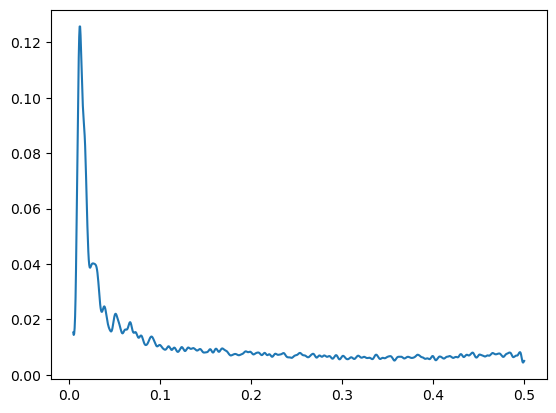

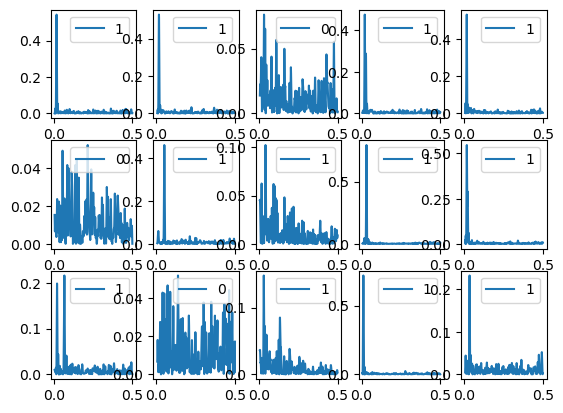

In [98]:
#Analyse dataset2
nb_planet = 4

#mean LS
indice = np.where( np.array(Nbr_planets) == nb_planet)
LS_pl = np.array(X_LS2)[indice]
Y_pl = np.array(Y2)[indice]
LS_mean = np.mean(LS_pl, axis=0)

#Print mean LS
plt.figure()
plt.plot(freq, LS_mean)

#Print LS
plt.figure()
k = 1
for i in range(3):
    for j in range(5):
        ind = random.randint(0,(nbr_periodogramme_set2/5)-1)
        plt.subplot(3,5,k), plt.plot(freq, LS_pl[ind], label = round(Y_pl[ind])), plt.legend()
        k+=1

# Test sous H0

In [109]:
A1, A2, A3  = 0.027, 0.003, 0.3*1e-3 # m/s
B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
cste        = 1.4e-4 # (m/s)**2/Hz

params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]



Y_gr = []
Y_act = []
Yerr = []

ls_gr = []
ls_act = []
ls_err = []

for i in range(1000):
    
    Prot = random.randint(10,90)#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

    amp  = gamma.rvs(2.0, 0.5) 
    epsilon = uniform.rvs(0.5, 1)
    tau = np.random.normal(3*Prot, 0.1*Prot)         
    gam  = 2.0/epsilon #not change
    logP = np.log(Prot) #not change 
    met  = 1.0 # not change 

    params_act = [amp, gam, logP, met]
    
    ygr, yact, yerr = generate_regular_data_H0(params_gr, params_act, len(t), t)
    Y_gr.append(ygr)
    Y_act.append(yact)
    Yerr.append(yerr)
    ls_gr.append(LombScargle(t, ygr).power(freq, method = 'cython') )
    ls_act.append(LombScargle(t, yact).power(freq, method = 'cython') )
    ls_err.append(LombScargle(t, yerr).power(freq, method = 'cython'))
    
y_gr_moy = np.mean(Y_gr, axis =0)
ls_gr_moy = np.mean(ls_gr, axis = 0)

y_act_moy = np.mean(Y_act, axis =0)
ls_act_moy = np.mean(ls_act, axis = 0)

yerr_moy = np.mean(Yerr, axis =0)
ls_err_moy = np.mean(ls_err, axis = 0)


(<Axes: >,
 <matplotlib.legend.Legend at 0x7fe21dca9150>)

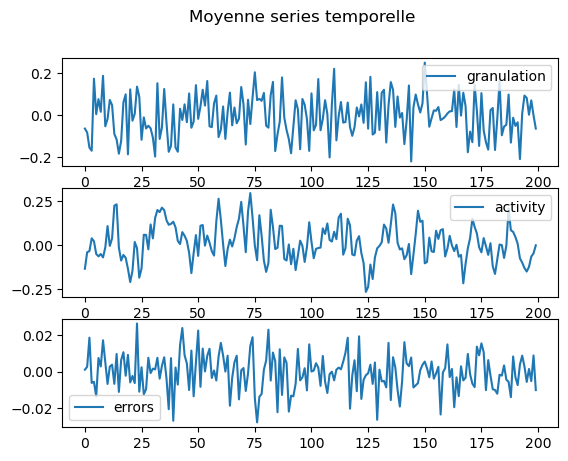

In [110]:
plt.suptitle("Moyenne series temporelle")
plt.subplot(311), plt.plot(y_gr_moy, label ='granulation'), plt.legend()
plt.subplot(312), plt.plot(y_act_moy, label='activity'), plt.legend()
plt.subplot(313), plt.plot(yerr_moy, label="errors"), plt.legend()

(<Axes: >,
 <matplotlib.legend.Legend at 0x7fe21da0ab90>)

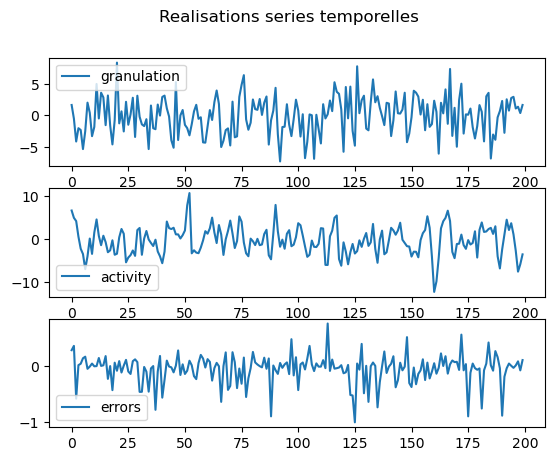

In [111]:
plt.suptitle("Realisations series temporelles")
plt.subplot(311), plt.plot(ygr, label ='granulation'), plt.legend()
plt.subplot(312), plt.plot(yact, label='activity'), plt.legend()
plt.subplot(313), plt.plot(yerr, label="errors"), plt.legend()

(<Axes: >,
 <matplotlib.legend.Legend at 0x7fe21d95ab30>)

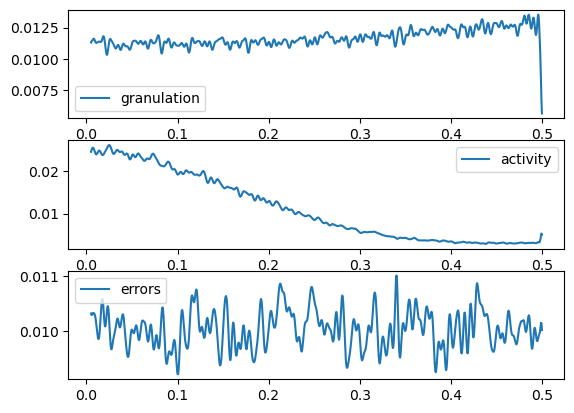

In [112]:
plt.suptitle("")
plt.subplot(311), plt.plot(freq,ls_gr_moy,label ='granulation'), plt.legend()
plt.subplot(312), plt.plot(freq,ls_act_moy, label='activity'), plt.legend()
plt.subplot(313), plt.plot(freq,ls_err_moy, label="errors"), plt.legend()

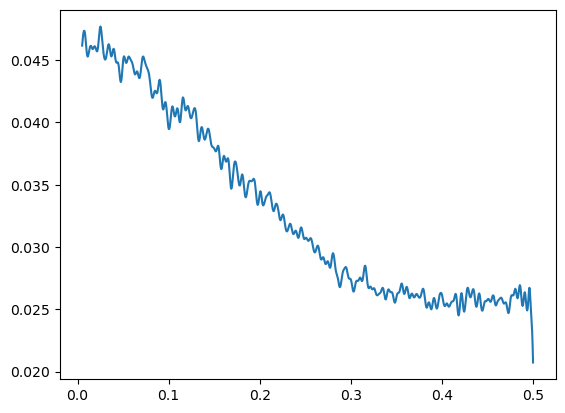

In [113]:
plt.plot(freq,ls_gr_moy + ls_act_moy +ls_err_moy)

# Basic test

(<Axes: >, <matplotlib.collections.PathCollection at 0x7fe21d04ece0>)

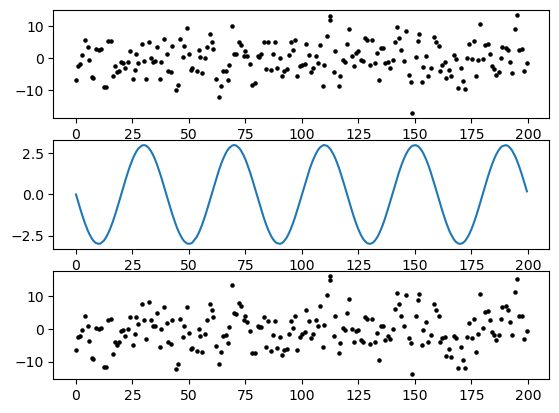

In [120]:
Ppl = 40
K = 3
T0 = 20
params_pl = Ppl, K, T0

ypl1 = generate_planete(params_pl, t)
ygr, yact, yerr = generate_regular_data_H0(params_gr, params_act, len(t), t)
y_noise = ygr + yact + yerr

ytot = y_noise + ypl1 + ypl2

plt.subplot(311), plt.scatter(t,y_noise, s = 5, c='k')
plt.subplot(312), plt.plot(t, ypl1)
plt.subplot(313), plt.scatter(t, ytot, s= 5, c='k')

(<Axes: >, [<matplotlib.lines.Line2D at 0x7fe21ce0b1c0>])

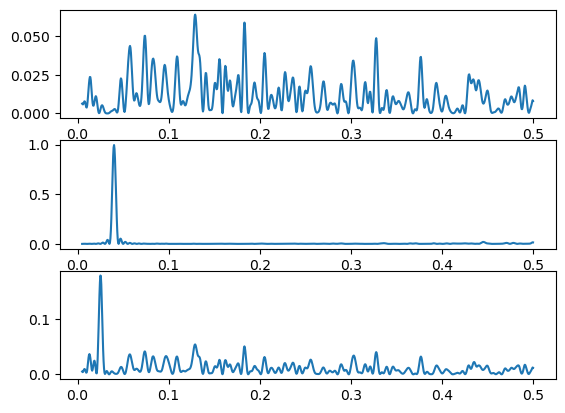

In [121]:
plt.subplot(311), plt.plot(freq, LombScargle(t,y_noise).power(freq,method='cython'))
plt.subplot(312), plt.plot(freq, LombScargle(t,ypl).power(freq,method='cython'))
plt.subplot(313), plt.plot(freq, LombScargle(t,ytot).power(freq,method='cython'))